In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [59]:
# Load the dataset
file_path = 'car.csv'
car_data = pd.read_csv(file_path)

# Display basic information
print("Dataset Info:\n")
car_data.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [60]:
# Handle missing values (if any)
car_data.dropna(inplace=True)

# Remove irrelevant columns
car_data.drop(columns=['Car_Name'], inplace=True)

In [61]:
current_year = 2024
car_data['Years_Since_Manufacture'] = current_year - car_data['Year']
car_data.drop(columns=['Year'], inplace=True)
car_data['Price_Per_Km'] = car_data['Selling_Price'] / car_data['Kms_Driven']
car_data['Log_Kms_Driven'] = np.log1p(car_data['Kms_Driven'])

In [62]:
# Encode categorical variables
car_data_encoded = pd.get_dummies(car_data, columns=['Fuel_Type', 'Seller_Type', 'Transmission'], drop_first=True)
# Handle outliers
def handle_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Specify columns to handle outliers
outlier_columns = ['Selling_Price', 'Present_Price', 'Kms_Driven']

# Apply outlier handling
car_data_encoded = handle_outliers(car_data_encoded, outlier_columns)


Statistical Summary:
        Selling_Price  Present_Price    Kms_Driven       Owner  \
count     276.000000     276.000000    276.000000  276.000000   
mean        3.754928       6.011848  32120.913043    0.036232   
std         3.067865       4.801373  20722.825248    0.187206   
min         0.100000       0.320000    500.000000    0.000000   
25%         0.750000       0.990000  15000.000000    0.000000   
50%         3.300000       5.835000  31213.500000    0.000000   
75%         5.675000       9.400000  45128.500000    0.000000   
max        12.900000      20.450000  92233.000000    1.000000   

       Years_Since_Manufacture  Price_Per_Km  Log_Kms_Driven  
count               276.000000    276.000000      276.000000  
mean                 10.250000      0.000226       10.051310  
std                   2.681757      0.000411        0.976348  
min                   6.000000      0.000001        6.216606  
25%                   8.000000      0.000043        9.615872  
50%          

C:\Users\SUMA\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


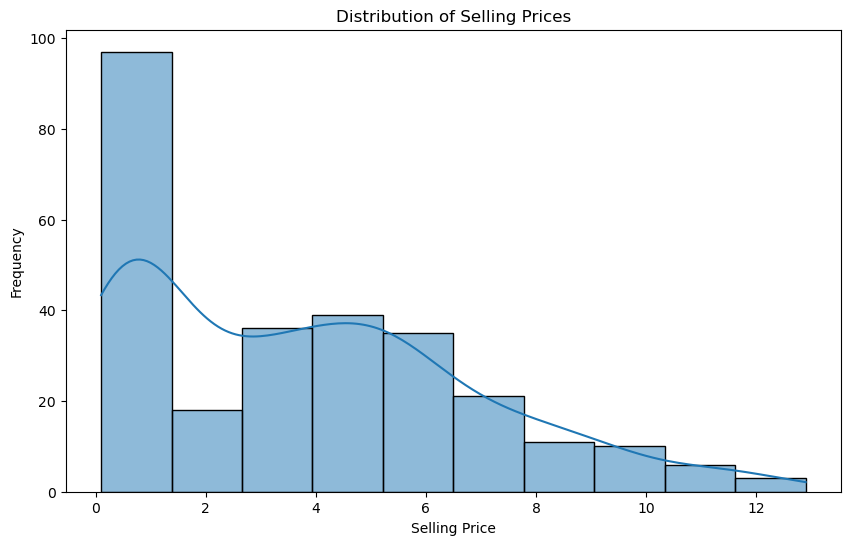

In [63]:
print("\nStatistical Summary:\n", car_data_encoded.describe())

# Distribution of Selling Prices
plt.figure(figsize=(10, 6))
sns.histplot(car_data_encoded['Selling_Price'], kde=True)
plt.title('Distribution of Selling Prices')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

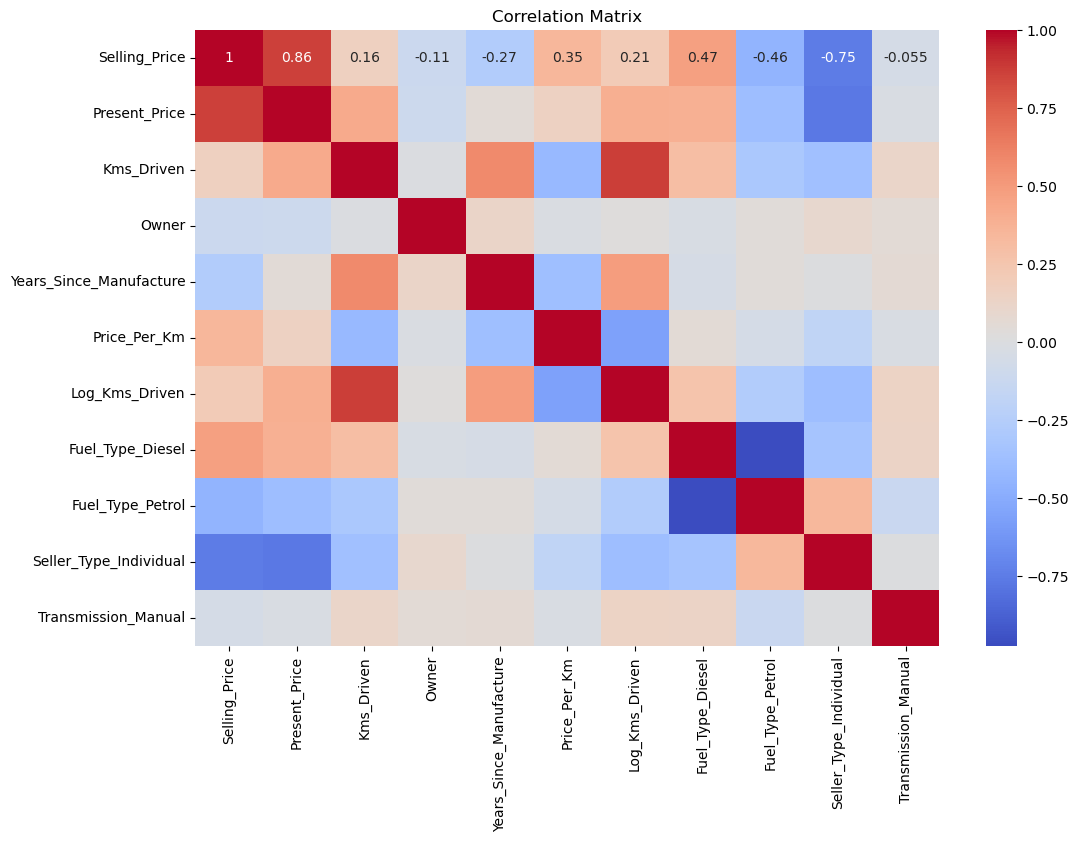

In [64]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(car_data_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [65]:
# Data Splitting
X = car_data_encoded.drop(columns=['Selling_Price'])
y = car_data_encoded['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Model Selection: Random Forest Regressor
rf = RandomForestRegressor()

# Hyperparameter Tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1200, num=12)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(5, 30, num=6)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)


In [ ]:
# Fit the model
rf_random.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
print("Best Parameters:\n", rf_random.best_params_)

# Train the best model
best_rf = rf_random.best_estimator_
best_rf.fit(X_train, y_train)


In [73]:
# Predictions
y_pred = best_rf.predict(X_test)
# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2 ): {r2}")


Model Performance:
Mean Absolute Error (MAE): 0.3482749999999948
Mean Squared Error (MSE): 0.305995864040174
Root Mean Squared Error (RMSE): 0.5531689290263635
R-squared (R2 ): 0.9646173885727806


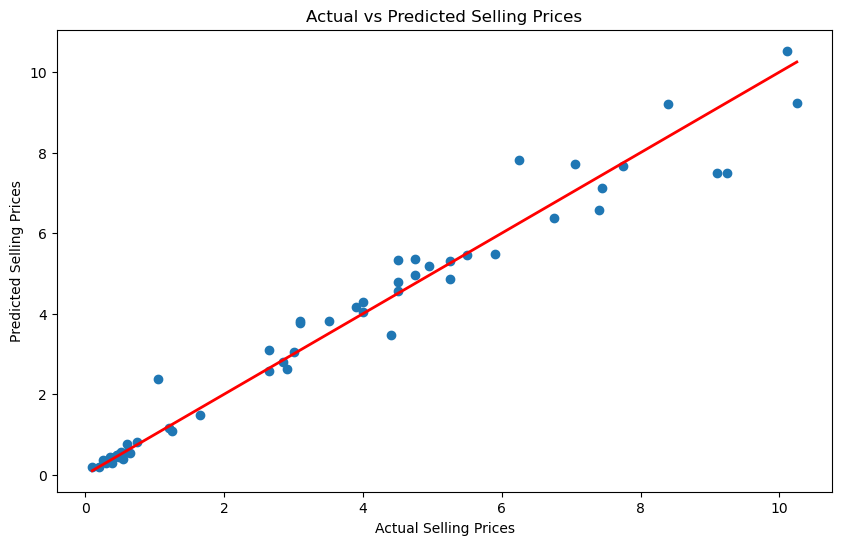

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.title('Actual vs Predicted Selling Prices')
plt.xlabel('Actual Selling Prices')
plt.ylabel('Predicted Selling Prices')
plt.show()

In [75]:
from joblib import dump, load
dump(best_rf, 'model.joblib')

['model.joblib']